In [28]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cmath as math
import sys

import scipy.cluster.hierarchy as sch
from sklearn.metrics import confusion_matrix

## Common functions

In [55]:
def success_ratio(cm):
    total_success = 0;
    total = 0
    
    for i in range(0, len(cm)):
        for j in range(0, len(cm[i])):
            if i == j: 
                total_success = total_success + cm[i, j]
                total = total + cm[i, j]
                
    return (100*total_success)/total

In [31]:
def getClusterAssignments(X, den):
    cluster_idxs = dict()
    cluster_rows = dict()
    colors_nums  = dict()
    col_num=0
    
    for c in np.unique(den['color_list']):
        cluster_idxs[c] = []
        colors_nums[c]  = col_num
        cluster_rows[col_num] = []
        col_num = col_num + 1

    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    rows_clusters = dict()
    for c, l in cluster_idxs.items():
        i_l = [den['ivl'][i] for i in l]
        col_num = colors_nums[c]
        cluster_rows[col_num] = i_l
        
        for i in i_l:
            rows_clusters[i] = col_num

    y_pred = []
    
    for i in range(0, len(X)):
        y_pred = np.append(y_pred, int(rows_clusters[str(i)]))

    return y_pred

In [56]:
def getOptimalNumberOfClusters():
    wcss_values = buildWCSSValues()
    elbowIndex = getElbowPointIndex(wcss_values)
    
    return elbowIndex

In [57]:
def buildWCSSValues(X):
    from sklearn.cluster import KMeans
    print("Building WCSS Data...")
    wcss_values = []
    tmax_clusters = int(math.sqrt(len(X)).real)
    stepstr = ''
    sys.stdout.write("Progression : ")
    
    for i in range(1, tmax_clusters) :
        sys.stdout.write('\b'*len(stepstr))
        stepstr = str(i) + "/" + str(tmax_clusters - 1)
        sys.stdout.write(stepstr)
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init = 10, random_state=0)
        kmeans.fit(X)
        wcss_values.append(kmeans.inertia_)
        
    return wcss_values

In [58]:
def getElbowPointIndex(wcss):
    curve = wcss
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint

In [59]:
def showWCSSElbowGraph(wcss_values, elbowIndex):
    max_wcss = max(wcss_values)
    max_clusters = len(wcss_values)
    nb_clusters = np.arange(1, max_clusters+1, 1)
    wcss_r = np.array(wcss_values)/max_wcss
    nb_clusters_r = (1 * np.array(nb_clusters))/max_clusters
    plt.plot(nb_clusters_r, wcss_r)
    lx1=nb_clusters_r[0]
    ly1=wcss_r[0]
    lx2=nb_clusters_r[max_clusters - 1]
    ly2=wcss_r[max_clusters - 1]
    plt.plot([lx1, lx2], [ly1, ly2], c='green')
    coef = (ly2 - ly1)/(lx2 - lx1)
    plt.plot([nb_clusters_r[elbowIndex], 1], [wcss_r[elbowIndex], wcss_r[elbowIndex] - coef], c='red')
    plt.title('WCSS value according to the number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS value')
    xticks = nb_clusters_r[0::1]
    xticks_lab = nb_clusters[0::1]
    plt.xticks(xticks, xticks_lab)
    ticks = np.arange(0, 1, 0.05)
    yticks = np.round(ticks * max_wcss) / max_wcss
    plt.yticks(yticks, (yticks*max_wcss).astype(int))
    plt.show()

In [61]:
import plotly
import plotly.graph_objs as go

def getTrace(x, y, z, c, label, s=2):
    trace_points = go.Scatter3d(
                        x=x, y=y, z=z,
                        mode='markers',
                        marker=dict(size=s, line=dict(color='rgb(0, 0, 0)', width=0.5), color=c, opacity=1),
                        name=label
    )
    return trace_points;

In [63]:
def showGraph(title, x_colname, x_range, y_colname, y_range, z_colname, z_range, traces):
    layout = go.Layout(
        title=title,
        scene = dict(
            xaxis=dict(title=x_colname, range = x_range),
            yaxis=dict(title=y_colname, range = y_range),
            zaxis=dict(title=z_colname, range = z_range)
        )
    )
    
    fig = go.Figure(data=traces, layout=layout)
    plotly.offline.plot(fig)

In [32]:
dataset  = pd.read_csv('E:\\MYLEARN\\2-ANALYTICS-DataScience\\datasets\\wheat.data')

In [33]:
dataset.head(10)

,id,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
0,0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,kama
1,1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,kama
2,2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,kama
3,3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,kama
4,4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,kama
5,5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,kama
6,6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,kama
7,7,14.11,14.10,0.8911,5.420,3.302,2.700,NaN,canadian
8,8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,kama
9,9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,kama


In [34]:
dataset.columns

Index(['id', 'area', 'perimeter', 'compactness', 'length', 'width',
       'asymmetry', 'groove', 'wheat_type'],
      dtype='object')

In [35]:
#loading the dataset
X     = dataset.iloc[:, [1, 2, 6]].values

y_set = dataset.iloc[:, [8]].values

(1) Method of __single linkage__ or nearest neighbour. 
- Proximity between two clusters is the proximity between their two closest objects. 
- The conceptual metaphor of this built of cluster, its archetype, is spectrum or chain. 
- Chains could be straight or curvilinear, or could be like "snowflake" or "amoeba" view. Two most dissimilar cluster members can happen to be very much dissimilar in comparison to two most similar. 
- controls only nearest neighbours similarity.

(2) Method of __complete linkage__ or farthest neighbour. 
- Proximity between two clusters is the proximity between their two most distant objects. 
- The metaphor of this built of cluster is circle (in the sense, by hobby or plot) where two most distant from each other members cannot be much more dissimilar than other quite dissimilar pairs (as in circle). Such clusters are "compact" contours by their borders, but they are not necessarily compact inside.

(3) __Average__ : Perform average/UPGMA linkage on a condensed distance matrix.

(4) __Centroid__: Performs centroid/UPGMC linkage on the condensed distance matrix y.

(5) __Median__  : Perform median/WPGMC linkage.

(6) __Ward__    : Perform Ward’s linkage on a condensed distance matrix.

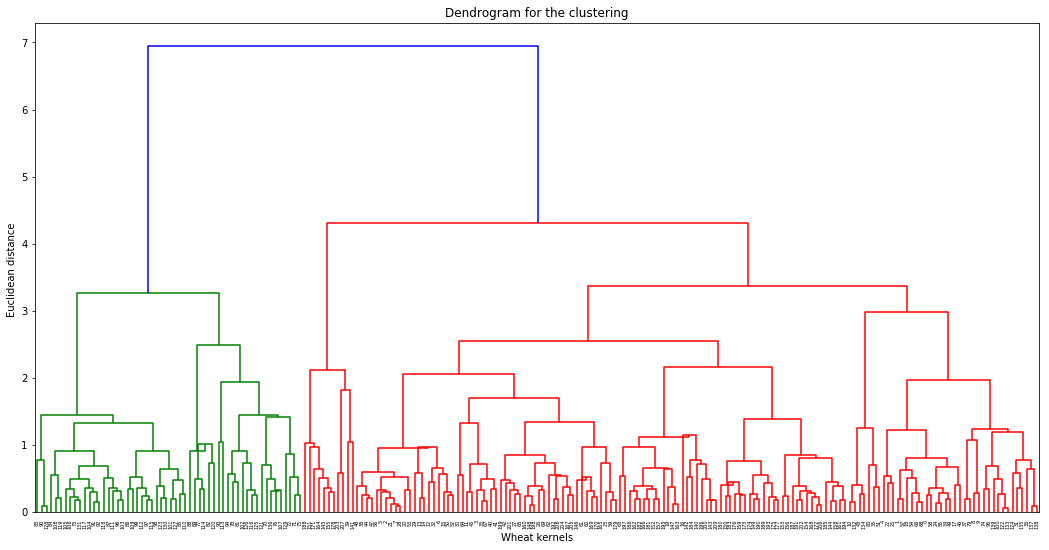

In [36]:
plt.figure(figsize=(18, 9))

# Perform hierarchical/agglomerative clustering.
Z = sch.linkage(X, method = 'median')

# Plot the hierarchical clustering as a dendrogram.
den = sch.dendrogram(Z)


plt.title('Dendrogram for the clustering')
plt.xlabel('Wheat kernels')
plt.ylabel('Euclidean distance ');

In [49]:
# get all the keys of the dendogram
den.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [47]:
# A list of color names. The k’th element represents the color of the k’th link.
np.unique(den['color_list'])

array(['b', 'g', 'r'], dtype='<U1')

In [52]:
y_pred = getClusterAssignments(X, den)


In [53]:
y_pred

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2.])

In [64]:
cm = confusion_matrix(y_set, y_pred)

print("success ratio : ",success_ratio(cm=cm), "%")

ValueError: Mix of label input types (string and number)